<h2 style = "text-align: center;">Advanced Data Science for Traffic and Transportation Engineering</h2>

<h3 style = "text-align: center;">Determine the Position of Road Inspectors - Rijkswaterstaat</h3><br><br>

<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <h3 style = "text-align: left;">Group 3</h3>
        <ul>
            <li>Yiman Bao (5691648)</li>
            <li>Juan Camargo Fonseca (5834112)</li>
            <li>Tijmen Hoedjes (4959183)</li>
            <li>Max Lange (5169402)</li>
            <li>Wail Abdellaoui (5130654)</li>
        </ul>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="Images/TUDelft_logo.jpg" width="300"/>
     </div>
</div>

### Content ###

**To be updated**


### 1. Introduction ###

To ensure safety on highways and a smooth traffic flow, road inspectors are  important. When accidents occur, they appear and make sure that the traffic can quickly resume. It is important for these people to show up as soon as possible when accidents happen. So, an optimal distribution of the inspectors to make sure that they will arrive shortly after the accident is necessary.

#### 1.1 Research Objective and Research Questions ####

The research objective is to find out the optimal location of inspectors in the Dutch road network, such that travel time to the incidents is minimized. For reaching this objective the following research question(s) are proposed. <br><br><b>Main Research Question:</b> What would be the optimal location of road inspectors in the Netherlands, such that travel times to incidents are minimized?

<b>Sub questions:</b>
<ol>
    <li> To what extent the data provided by Rijkswaterstaat is useful for the research objective? </li>
    <li> How do the incidents distribute in time and space in the Dutch network? </li>
    <li> What type of method is suitable for evaluating the accident probabilities? </li>
    <li> What are the locations in which accidents are more likely to happen? </li>
    <li> What variables would affect the response time of the inspectors? </li>
    <li> How to calculate the response time of the inspectors?  </li>
    <li> What is the optimal number of road inspectors needed?  </li>
    <li> What is the optimal location for the road inspectors?  </li>
</ol>
    
#### 1.2 Tech Stack ####

Given the requirement of this project, the following is the tech stack that will be used for reaching the research objective.

<b> Coding: </b>The main programming language used will be Python, and necessary packages for data analytics such as Pandas, NumPy, GeoPandas, SciPy and scikit-learn will be imported as necessary.

<b> Visualization: </b>For standard data visualization, Python libraries such as Matplotlib, Plotly and Seaborn will be employed. For Geospatial visualization, additional tools such as Folium and Rasterio are considered.

<b> Version Control: </b>Git and GitHub will be used for code tracking and collaboration.

<b> Communication: </b>Weekly in-person meetings are planned. However, Microsoft Teams can be used as necessary.

<b> Documentation: </b>Jupyter Notebooks will be used for documenting code, analysis, results and conclusions.

The following code block imports the necessary packages and libraries.

In [1]:
%matplotlib inline
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import json
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from datetime import datetime
import numpy as np

from IPython.display import display
import ipywidgets as widgets

from folium.plugins import HeatMap
import seaborn as sns

import data_filtering
import Visualize

## 2. Data Analysis <br>

### 2.1 Data description ###

For the development of the project, two major datasets were provided. The first one of them is a shapefile of the main elements of the dutch motorway network, in which basic geometric and functional data is included. The second dataset is a csv file of 88,851 incidents that ocurred in this network in the year 2019; for every incident, information regarding location, classification, starting time, end time and road number is included.

### 2.2 Preprocessing and data cleaning ###

After an initial exploration of the data, it was clear that some preprocessing and filtering was neccesary. For doing so, the following criteria was considered:

<ol>
    <li>Incidents that occurred in roads not included in the NWD Road Network Data.</li>
    <li>Incidents that had a duration of zero (0) minutes or lasted longer than one day.</li>
       
</ol>

After applying these procedures, a total of 13,172 incidents were removed. 

In [2]:
#Extract subnetwork
highway_shapefile = 'Data/Shapefiles/Snelheid_Wegvakken.shp'
network_temp = gpd.read_file(highway_shapefile)

path = 'Data/incidents19Q3Q4.csv'
df_incident = pd.read_csv(path)
path1 = 'Data/incidents19Q3Q4.csv'
df_incident_unfilter = pd.read_csv(path1)

df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])
df_incident['endtime_new'] = pd.to_datetime(df_incident['endtime_new'])

# filter the data
df_incident = data_filtering.filter_out(df_incident, network_temp)

### 2.3 Distribution of incidents over time ###

In [3]:
Visualize.distribution_time(df_incident, 'day')

interactive(children=(Dropdown(description='Incident Type:', options=('all', 'vehicle_obstruction', 'general_o…

To be able to determine the distribution of road inspectors contextual information will be collected. We start by analysing the hourly incident distribution . Temporal patterns are visible from this plot. In the figure above you can see the distribution of incidents over the day, hourly. The peak hours can be clearly seen, there are two of them: one in the morning (7 till 8) and one in the late afternoon(16:00 - 18:00). During these peak hours a larger deployment of inspectors is needed. 

For the accdient and vehicle_obstruction, they both have ditinct peak hour periods, especially for the accident. But for the general_obstruction, it doesnit show phenomenon. Since 6 am, the number of general_obstruction start to rise and reach the peak at 3 pm. 

In [4]:
Visualize.distribution_time(df_incident, 'week')

interactive(children=(Dropdown(description='Incident Type:', options=('all', 'vehicle_obstruction', 'general_o…

For the distribution over week, the number of incidents don't change much and the differenct types of incident are looks similar. There are also a few incident happened at Saturday. Because they were recorded very close to the midnight on Friday.

In [5]:
Visualize.distribution_time(df_incident, 'year')

interactive(children=(Dropdown(description='Incident Type:', options=('all', 'vehicle_obstruction', 'general_o…

The distribution over months shows July has the least incidents, because the the data collection started on 30th July. Besides this, there were fewer incidents in November than in other months. But for the accident, August is the lowest.

In [8]:
def distribution_in_day(df_incident):
    df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])
    df_incident['endtime_new'] = pd.to_datetime(df_incident['endtime_new'])
    df_incident['Hour'] = df_incident['starttime_new'].dt.hour

    hourly_counts = df_incident.groupby(['type', 'Hour']).size().unstack(fill_value=0)
    return hourly_counts

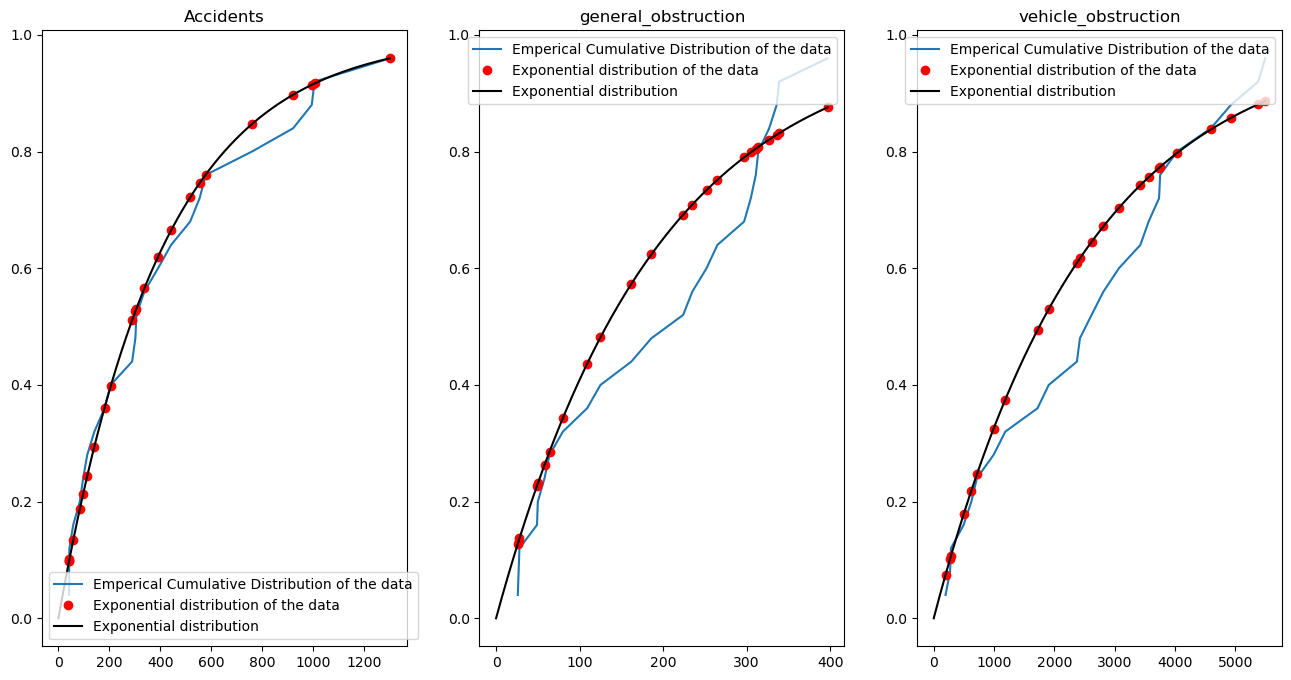

In [9]:
def calculate_ecdf(data):
    sorted_data = data.sort_values()
    p_data = np.zeros(len(sorted_data))
    for i in range(len(p_data)):
        p_data[i] = (i+1) / (len(p_data) + 1)
    ecdf = pd.DataFrame({'F_x':p_data, 'Sorted Data':sorted_data})
    return ecdf

def F_exponential(data, mean):
    return 1 - np.exp(-data/mean)

plt.figure(figsize=(16, 8))
title = ['Accidents', 'general_obstruction', 'vehicle_obstruction']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(calculate_ecdf(distribution_in_day(df_incident).iloc[i])['Sorted Data'], 
             calculate_ecdf(distribution_in_day(df_incident).iloc[i])['F_x'], label='Emperical Cumulative Distribution of the data')
    plt.plot(distribution_in_day(df_incident).iloc[i], F_exponential(distribution_in_day(df_incident).iloc[i], 
                                                                     np.mean(distribution_in_day(df_incident).iloc[i])), 'ro', 
             label='Exponential distribution of the data')
    plt.plot(np.linspace(0, np.max(distribution_in_day(df_incident).iloc[i]), np.max(distribution_in_day(df_incident).iloc[i])), 
             F_exponential(np.linspace(0, np.max(distribution_in_day(df_incident).iloc[i]), np.max(distribution_in_day(df_incident).iloc[i])), 
                           np.mean(distribution_in_day(df_incident).iloc[i])), 'k', label='Exponential distribution')
    plt.legend()
    plt.title(f'{title[i]}');

Looking to the emperical distribution of the amount of accidents, general obstruction and vehicle obstruction of every hour of the day, there has been founded that the emperical distribution of accidents looks like an exponential distribution. However, the emperical distribution of the general and vehicle obstruction does not fit the exponential distribution as well. This exponential distribution explain how many percent of the amount of accidents every hour has a higher or lower value than X accidents in that hour.

### 2.4 Duration of incident ###

In [6]:
Visualize.distribution_duration(df_incident)

interactive(children=(Dropdown(description='Incident Type:', options=('all', 'vehicle_obstruction', 'general_o…

As we assume that every incident requires one inspector indepent of the duration, the duration is not crucial in determining the number of inspectors allocated to larger accidents. However, it still provides valuable information because if a road inspector is responding to an incident with a longer duration, it is important to have another road inspector nearby to respond to incidents that may occur within the same moment. 

In the distribution of duration of accidents, most accidents last about 80 minutes.

### 2.5 Type of incidents ###

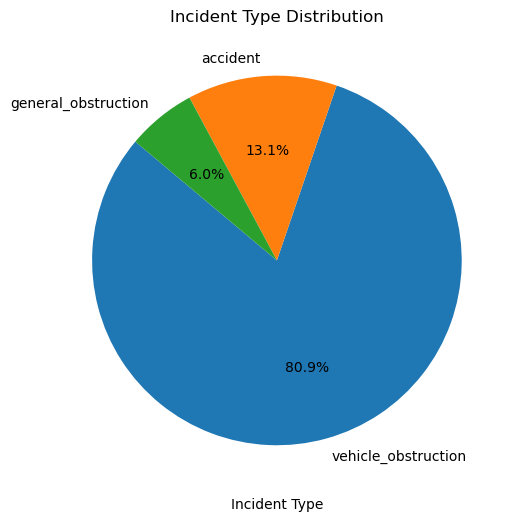

In [7]:
Visualize.type_distribution(df_incident)

The incident type may not influence immediate may the optimum ethod to identify the locations of road inspectors to reach the
hotspots < 18mins.This insightcan be valuable when we later want to come up with the deployment strategy of road inspectors based on incident types. 


### 2.6 Number of accidents that occurred at the same time ###

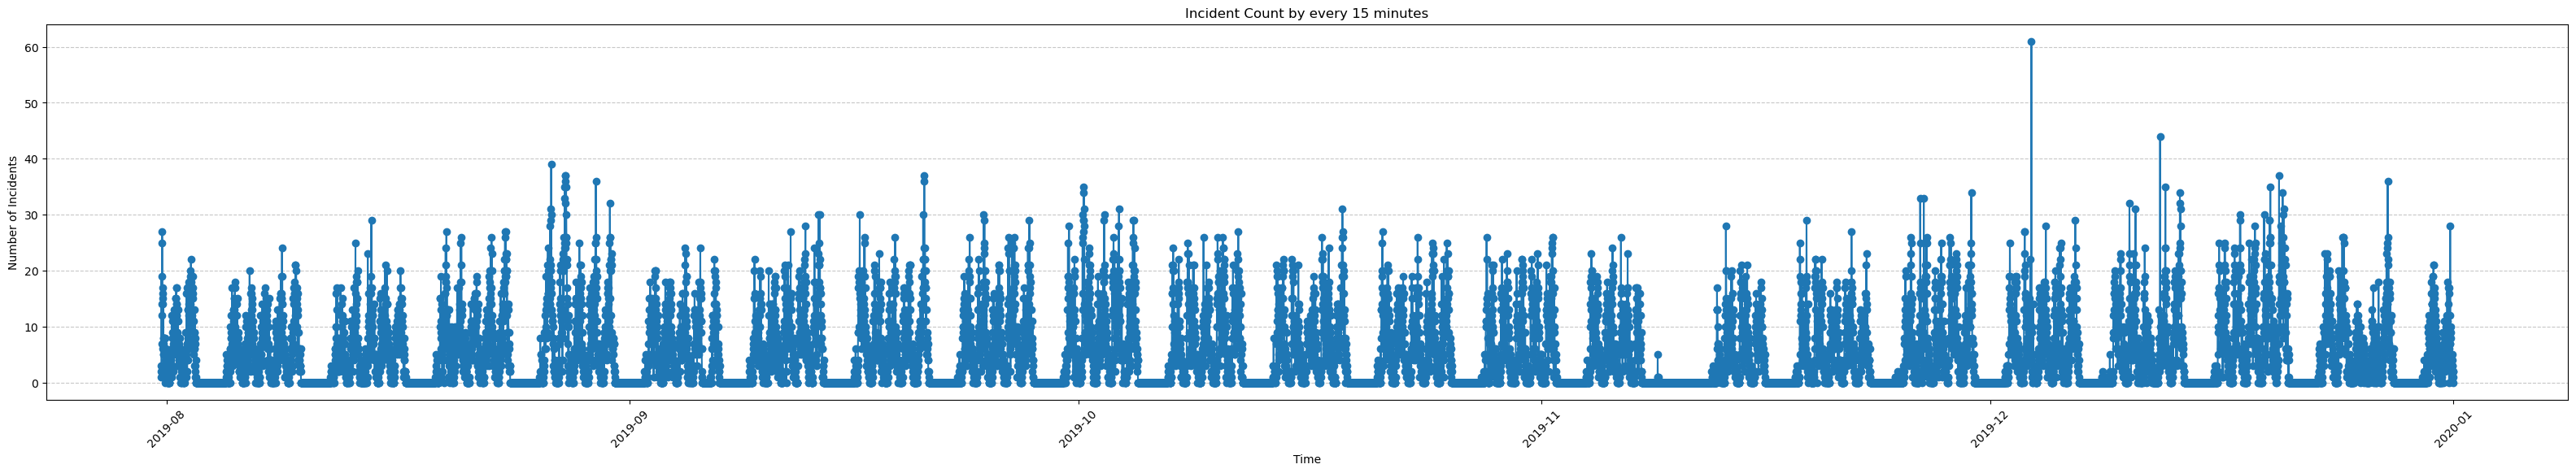

(Timestamp('2019-12-03 18:15:00'), 61)

In [8]:
Visualize.simultaneous_accidents(df_incident)

In the plot above the amount of incidents that occured simultaneously. It highlights a correlation between peak hourly incident occurrences and the number of incidents happening at the same time , which is valuable for allocating the road inspectors. In most situations, there are about 30 incidents happened at the same time. 

### 2.7 Locations of accidents ###

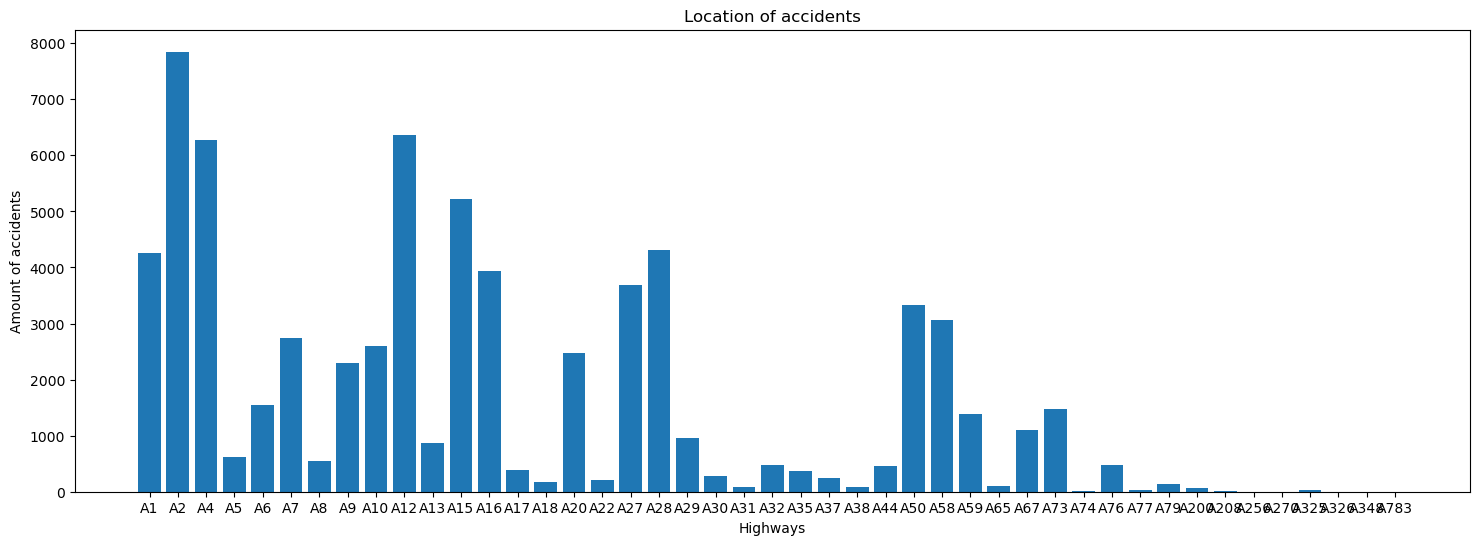

In [10]:
highways = ['A1', 'A2', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A12', 'A13', 'A15', 'A16', 'A17', 'A18', 'A20', 'A22',
           'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A35', 'A37', 'A38', 'A44', 'A50', 'A58', 'A59', 'A65', 'A67', 'A73',
           'A74', 'A76', 'A77', 'A79', 'A200', 'A208', 'A256', 'A270', 'A325', 'A326', 'A348', 'A783']
count = np.zeros(len(highways))
for i in range(len(df_incident['vild_primair_wegnummer'])):
    for j in range(len(count)):
        if df_incident['vild_primair_wegnummer'].iloc[i] == highways[j]:
            count[j] += 1

data_locations_df_accidents = {'Amount of accidents' : count}
locations_df_accidents = pd.DataFrame(data=data_locations_df_accidents, index=highways)

plt.figure(figsize=(18, 6))
plt.bar(np.arange(0, len(locations_df_accidents)), locations_df_accidents['Amount of accidents'])
plt.xticks(ticks=(np.arange(0, len(locations_df_accidents))), labels=highways)
plt.title('Location of accidents')
plt.ylabel('Amount of accidents')
plt.xlabel('Highways');

This graph shows the amount of accidents at every highway. Since there are too many highways which makes this graph not good visibile, there will be maded a new graph which shows only the highways with more than 1000 accidents.

C:\Users\86180\AppData\Local\Temp\ipykernel_14048\821891343.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  density_big_locations_accidents[i] = big_locations_df_accidents.iloc[i] / length_big_locations_df_accidents[i]


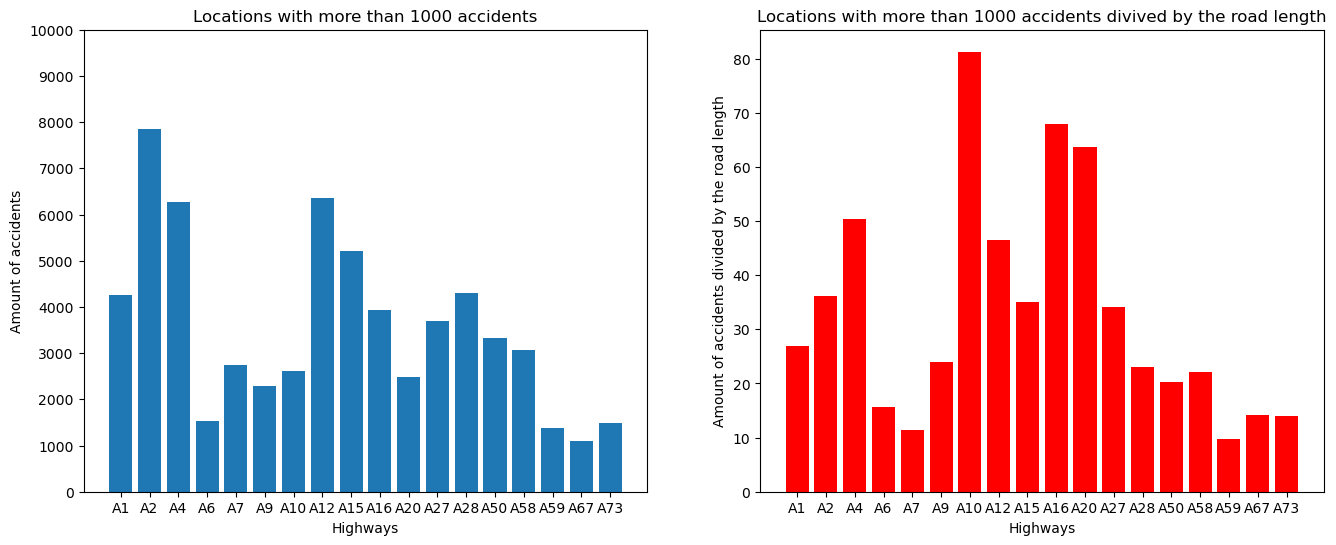

In [12]:
big_locations_df_accidents = locations_df_accidents[locations_df_accidents['Amount of accidents'] > 1000]
length_big_locations_df_accidents = [157.733, 217.098, 124.723, 98, 240.969, 95.673, 32.067, 136.818, 149, 57.898, 38.862, 107.826, 187.471, 
                                     164.724, 138.916, 142, 77.881, 105.713]

density_big_locations_accidents = np.zeros(len(big_locations_df_accidents))
for i in range(len(density_big_locations_accidents)):
    density_big_locations_accidents[i] = big_locations_df_accidents.iloc[i] / length_big_locations_df_accidents[i]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.bar(np.arange(0, len(big_locations_df_accidents)), big_locations_df_accidents['Amount of accidents'])
plt.xticks(ticks=(np.arange(0, len(big_locations_df_accidents))), labels=['A1', 'A2', 'A4', 'A6', 'A7', 'A9', 'A10',
                                                               'A12', 'A15', 'A16', 'A20', 'A27', 'A28',
                                                               'A50', 'A58', 'A59', 'A67', 'A73'])
plt.xlabel('Highways')
plt.ylabel('Amount of accidents')
plt.title('Locations with more than 1000 accidents')
plt.ylim(0, 10000)
plt.yticks(np.arange(0, 10000+1000, 1000))

plt.subplot(1, 2, 2)
plt.bar(np.arange(0, len(big_locations_df_accidents)), density_big_locations_accidents, color='red')
plt.xlabel('Highways')
plt.ylabel('Amount of accidents divided by the road length')
plt.title('Locations with more than 1000 accidents divived by the road length')
plt.xticks(ticks=(np.arange(0, len(big_locations_df_accidents))), labels=['A1', 'A2', 'A4', 'A6', 'A7', 'A9', 'A10',
                                                               'A12', 'A15', 'A16', 'A20', 'A27', 'A28',
                                                               'A50', 'A58', 'A59', 'A67', 'A73']);

The left (blue) graph gives a better visualisation than the first graph. This graphs shows the fact that the A2 has the most accidents and the A67 the lowest. However, the length of each highway should also be included in this graph to compare the amount of accidents at each highway relatively. In the right (red) graph, the amount of accidents divided by the length of each highway is shown. The outcome number is not a known parameter of a known formula (accidents per km) but it represents a good value to compare the amount of accidents relatively with the other highways.

When looking to the right graph, there is seen that the A10 has relatively the highest accidents and the A16 and A20 are second and third on this list. The A10 goes only through Amsterdam since it is a circle road. The A16 and A20 goes both through Rotterdam, the A20 is longer than the A16. The fourth highway with the highest accidents per km is the A4 which goes from Rotterdam through The Hague to Amsterdam. So, this data show that the highways which pass big cities like Amsterdam, Rotterdam and The Hague (in The Netherlands the collection of these cities and the fourth big city of the Netherlands, Utrecht, is called the 'Randstad') are the most dangerous highways.

### 2.8 Map of Incident and Network ###

In [11]:
map = Visualize.import_network_to_map('Data/Shapefiles/Snelheid_Wegvakken.shp')
map = Visualize.add_point_to_map(df_incident, map)

In the function import_network_to_map, we import the network on the map and import the point data into the map in the functioin add_point_to_map. The point data of incidents imported in the map includes the ID, type and start time of the incident. And the functioin add_point_to_map clustered all points automatically while while importing them. When the map is zoomed in or out, points within the view will be reclustered. At the same time, click on the cluster and it will be divided into smaller clusters until it becomes a point. In the results, when the view is zoomed in to the whole country, all incident points are divided into 8 clusters. Among them, the cluster in the Amsterdam-The Hague-Rotterdam area contains the vast majority of incident points, with as many as 49,732, more than half of the total. The cluster in the Eindhoven area has the second most points, with a total of 11,578. However, clusters in the northeast and southwest regions of the country contain relatively few points.

### 2.9 Heat map ###

In [13]:
heatmap = Visualize.create_heatmap(df_incident, map)

d:\anaconda\envs\geospatial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\anaconda\envs\geospatial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\anaconda\envs\geospatial\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\envs\geospatial\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

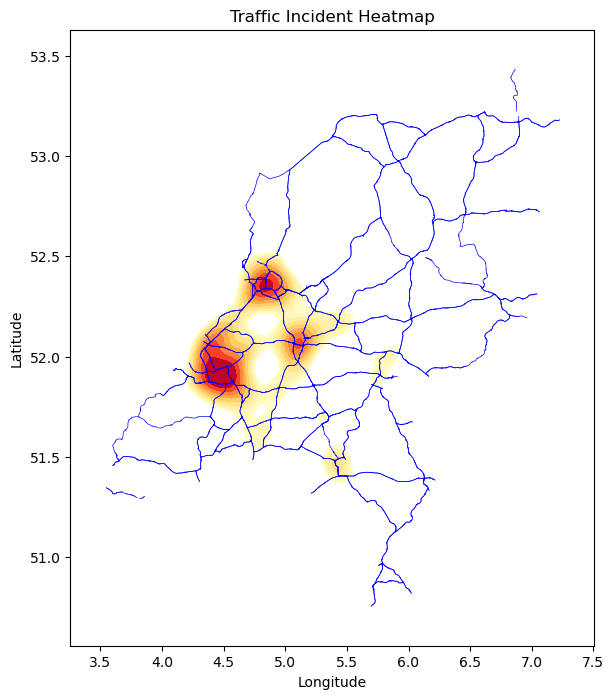

In [14]:
Visualize.heatmap_simple(df_incident, network_temp)

In the function create_heatmap, we originally planned to project the point data onto the map in the form of a heat map through folium.plugins.heatmap. However, due to too much point data, the results are not ideal. Almost all areas around the road network are red with high incident rates. However, due to too much point data, the results are not ideal. Almost all areas around the road network are red with high incident rates. In order to highlight the high-incident areas, in the function heatmap_simple, we use heatmap_simple's kdeplot to draw the heat map. Considering the function's running speed, we only project it into the road network instead of the entire map. Its results clearly show three high-incidence areas, the largest of which is the Hague-Rotterdam area, followed by the Amsterdam area and finally the Utrecht area. All three areas show a distinct red color. Then there are three yellow zones, Breda, Eindhoven and Arnhem.

### 2.10 Spatio-Temporal Map ###

In [15]:
Visualize.spatio_temporal(df_incident, network_temp, 15)

interactive(children=(SelectionSlider(continuous_update=False, description='time window:', options=(Timestamp(…

interactive(children=(SelectionSlider(continuous_update=False, description='time window:', options=(Timestamp(…

The purpose of function spatio_temporal is mainly to analyze the spatiotemporal distribution of various types of incidents. It can visualize the specific location and type of incidents in the road network that occurred in each time window. Considering the function running time and output result size issues, the function only projects the incident points into the road network instead of the map.

In this result, the time window we selected is 15 minutes. By moving the slider, we find that the spatiotemporal distribution of incidents is basically consistent with our previous analysis. More incidents occur on the road networks surrounding major cities such as Amsterdam, Rotterdam and The Hague. At the same time, incidents are mainly concentrated in the morning and evening peak hours, and there are fewer accidents late at night.

## 3. Ethic Analysis <br>

For this project, a Value Sensitive Design approach is to be followed, for which the stakeholders of the project need to be identified, along with their values and possible value conflicts that may arise. The first stakeholder is Rijkswaterstaat, owner of the project and provider of the data, as previously state, its main goal is to optimize the response time of the road inspectors when an incident occurs on the road network, however they have limited inspector capacity. Another stakeholder are the road users, for which the motorway network represents a way of meeting they daily needs, and who expect the network to be safe and to enable them to travel from A to B in the least possible time. Finally, another important stakeholder to be considered is police and law enforcement, as sometimes incidents can involve fatalities or injuries, in those cases it is necessary to carry out specific procedures in which they need to be involved.<br><br>
Different values can be recognized from these perspectives: in the case of Rijkswaterstaat, efficiency and sustainability are the main driving factors, whereas from users’ perspective safety and reliability are important, and from law enforcement’s side privacy and due diligence are relevant as well. Unfortunately, these objectives cannot be met simultaneously in the project; for example, if many inspectors are assigned to the network, response time can be optimized but the sustainability of the project will be compromised, as well as user safety and ability to travel in the least time possible; the other way around also generates conflicts, as having few inspectors will harm efficiency and also cooperation with authorities in case it is needed.<br><br>
On the other hand, the following issues regarding privacy, fairness and bias were identified:
<ol>
    <li>Data collection period is autumn/winter. (<b>bias</b>).<br><br> First, the incident data collection period is from August to December, which may cause some bias in the incident analysis results as only late summer, fall and early winter seasons are represented. For example, weather conditions can vary significantly between seasons, with fall potentially being more prone to rainy days and falling leaves, while early winter can be accompanied by cold weather and ice and snow, leading to differences in the type and frequency of incidents in different seasons. Finally, traffic flow on the roads may differ by season, due to holidays or special events that can take place, a feat that may affect the occurrence of incidents, making the analysis prone to flow-related biases if this is not accounted for.</li><br>
    <li>Accidents can have some privacy issues (police, insurance claims, etc.) (<b>privacy</b>).<br><br> Privacy issues in accident data analysis may have some important impacts on the results. Due to privacy concerns, some sensitive information may have been removed or anonymized, resulting in limited availability of the data. This may result in missing or incomplete data sets, compromising the comprehensiveness of the accident analysis. Missing critical information may bias the results of the analysis, as all relevant factors cannot be considered. At the same time, data sampling may be limited due to privacy issues. Certain types of accidents or accidents for specific groups of people may not be adequately reflected in the data. This can lead to sampling bias, making the results less representative of the overall situation. Most importantly, however, relevant legal and ethical regulations must be followed when handling incident data to ensure that individual privacy rights are respected. These legal provisions may restrict the use, storage and sharing of data. Violating these regulations may lead to legal issues and may also affect the availability and quality of the data.</li><br>
    <li>Algorithm prioritizing criteria (<b>Bias</b>) <br><br> After data processing and filtering, a large majority of the reported incidents occurred in motorways (A roads), while less than 7% of the data was reported in national highways (N roads). We consider that this can bring bias to the project in two manners, depending on the approach. The first one of them is representation bias, meaning that the main focus of the model will be on motorways and thus the solution devised may not capture the necessary features to devise an optimal inspector assignment for national highway. The second way in which this can bring a bias to the model is that the impact of a disruption may vary depending on the road type in which it occurs. Solely optimizing the response time of the road inspectors will result in a ‘first come, first served’ approach. This will mean that, if an incident in a motorway and another incident in a national highway occur close in time, the inspector assignment may not be optimal at a network level. </li><br>
    <li>Representation bias: unequal representation of accident types (<b>bias</b>)<br><br>Following a similar line of reasoning, around of 80% of the incidents reported correspond to vehicle obstructions, 13% correspond to accidents, and the remaining 7% are catalogued as general obstructions. In consequence, general trends will be like the vehicle obstruction category, and the model obtained can have a better performance for these than for accidents and general obstructions, which may undermine its capability to optimize the road position.</li><br>
    <li> Data linkage (privacy) 
    Data from incidents involving citizens is used. The data itself does not reveal anything about individuals. However, combining this data with other information can lead to serious privacy violations. Therefore, sharing the data with other parties should be prohibited, also transparency about the use of data is important.
    
</ol>

## 4. Algorithm <br>